In [2]:
import torch
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
import copy
import sys
import matplotlib as mpl
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing


# Get the parent directory of the current directory
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from model.diffusion.diffusion_proc import Diffusion, linear_noise_schedule
from model.diffusion.unet import Unet
from model.diffusion.dataset import CondSeqImageDataset

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR =  "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/evaluation_data" # os.path.join(VOL_PATH, "diss_ag/data/frame_data_dist/state_2")
MODEL_PATH = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_10000samples_fixedParams.pt"

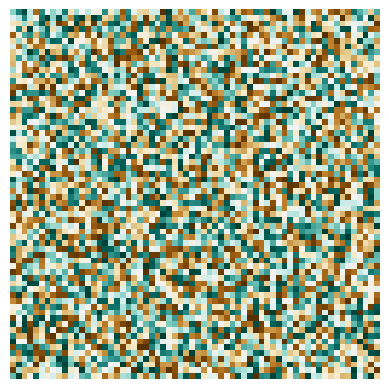

In [17]:
noise = np.random.rand(64, 64)
plt.imshow(noise, cmap="BrBG")
plt.axis("off")
plt.show()

0.6865342 0.0 0.23086241


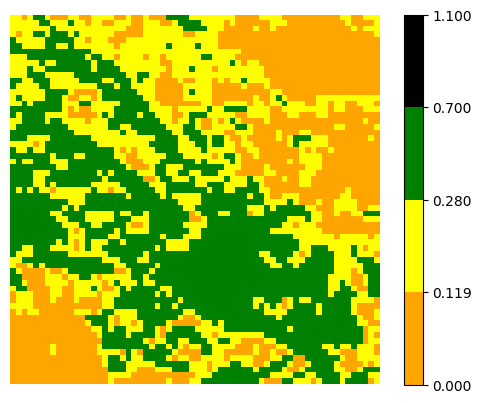

In [98]:
# custormize colorbar
cmap = mpl.colors.ListedColormap(['orange','yellow', 'green', 'black'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds =  [0.0,0.1188,0.2798,0.7,1.1] #[0.0,0.2488,0.3098,0.7,1.1] # [1.0, 2.02, 2.27, 3.5, 5.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

BACKGROUND_PATH = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/background.mpy"
with open(BACKGROUND_PATH, 'rb') as f:
    background_img = pickle.load(f)
    print(np.max(background_img), np.min(background_img), np.mean(background_img))

plt.imshow(background_img, cmap=cmap, norm=norm)
plt.colorbar()
plt.axis("off")
plt.show()

# binary custom cmap
binary_cmap = mpl.colors.ListedColormap(['cyan', 'yellow'])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
diff_model =  Unet(
    in_ch=1,
    cond_ch=1,
    model_ch=96,
    output_ch=1,
    channel_mult=(1, 2, 2),
    attn_res=[],
)
diff_model.load_state_dict(torch.load(MODEL_PATH))
diff_model.to(device)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0): TimestepSeqEmbedding(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSeqEmbedding(
      (0): ResBlock(
        (conv_1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_embedding): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (condition_conv): Sequential(
          (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): SiLU()
        )
        (conv_2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

simulated_data = CondSeqImageDataset(DATA_DIR, transform=transform)

In [94]:
def plot_images_in_row(images, starting_image=None, type_output="simulation", mismatch_stat=None):
    """
    Function to plot 5 images in a single row, side by side.

    Parameters:
    - images: List or array of 5 images to be plotted.
    - starting_image: An optional starting image to be displayed in the first subplot.
    """

    # Ensure the input images are in a list or array and exactly 5 images
    assert len(images) == 4, "The images array must contain exactly 4 images."
    
    # Create a figure with a grid layout with 1 row and 6 columns
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))

    # Plot the starting image if provided
    if starting_image is not None:
        if type_output != "mismatch":
            start_img = starting_image.cpu().squeeze().squeeze()
            combined_img = np.where(start_img == 1, 1, background_img)
            axes[0].imshow(combined_img, cmap=cmap, interpolation="none", norm=norm)
            axes[0].set_title('Starting State t=0')
            axes[0].axis('off')
        else:
            axes[0].imshow(starting_image.cpu().squeeze().squeeze(), cmap="binary_r")
            axes[0].set_title('Starting State t=0')
            axes[0].axis('off')
    else:
        axes[0].axis('off')  # Hide the first subplot if no starting image is provided

    # Plot the 5 images
    for i in range(4):
        if type_output != "mismatch":
            img = images[i]
            combined_img = np.where(img == 1, 1, background_img)
            axes[i + 1].imshow(combined_img, cmap=cmap, interpolation="none", norm=norm)
            if type_output=="simulation":
                axes[i + 1].set_title(f'Simulated t = {(i+1) * 5}')
            elif type_output=="predicted":
                axes[i + 1].set_title(f'Predicted t = {(i+1) * 5}')
            axes[i + 1].axis('off')
        else:
            img = images[i]
            mismatch_perc = mismatch_stat[i]
            axes[i + 1].imshow(img, cmap=binary_cmap)
            axes[i + 1].set_title(f'Mismatch t = {(i+1) * 5} | {mismatch_perc}%')
            axes[i + 1].axis('off')

    # Adjust the layout
    plt.tight_layout()
    plt.show()
    

In [96]:
diffusion = Diffusion(timesteps=500, noise_schedule='linear')

def generate_predictions(t_0, diff_client, num_preds=4):
    
    input_img = t_0

    input_img = input_img.to(device).float().unsqueeze(0)
    image_size = input_img.shape[-1]
    channels = input_img.shape[1]

    input_arr = [input_img]
    outputs = []
    for i in range(num_preds):
        generated_images = diff_client.sample(
            model=diff_model,
            image_size=image_size,
            cond_img=input_arr[-1],
            batch_size=1,  # Set the desired batch size
            channels=channels,
            w=2,
            clip_denoised=True
        )
        otpt = generated_images[-1].squeeze().squeeze()
        otpt = np.where(otpt <= 0.5, 0, otpt)
        otpt = np.where(otpt > 0.5, 1, otpt)
        
        outputs.append(otpt)
        
        
        next_input = transform(otpt).to(device).float().unsqueeze(0)
        input_arr.append(next_input)

    return outputs

def compute_pixel_mismatch(image1, image2):
    """
    Compute the pixel mismatch between two binary images and return a binary image representing the mismatch.

    Parameters:
    - image1: numpy array representing the first binary image.
    - image2: numpy array representing the second binary image.

    Returns:
    - mismatch_image: A binary image where mismatched pixels are 1 and matching pixels are 0.
    """
    # Convert torch tensors to numpy arrays if needed
    if isinstance(image1, torch.Tensor):
        image1 = image1.numpy()
    if isinstance(image2, torch.Tensor):
        image2 = image2.numpy()
    # Ensure both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")
    
    # Compute the mismatch by comparing the images
    mismatch_image = (image1 != image2).astype(int)  # Convert boolean array to integer array
    
    # Calculate the percentage of mismatched pixels
    total_pixels = image1.size
    mismatched_pixels = np.sum(mismatch_image)
    mismatch_percentage = round((mismatched_pixels / total_pixels) * 100, 3)
    
    return mismatch_image, mismatch_percentage


80 96


sampling loop time step: 100%|██████████| 500/500 [00:19<00:00, 25.89it/s]


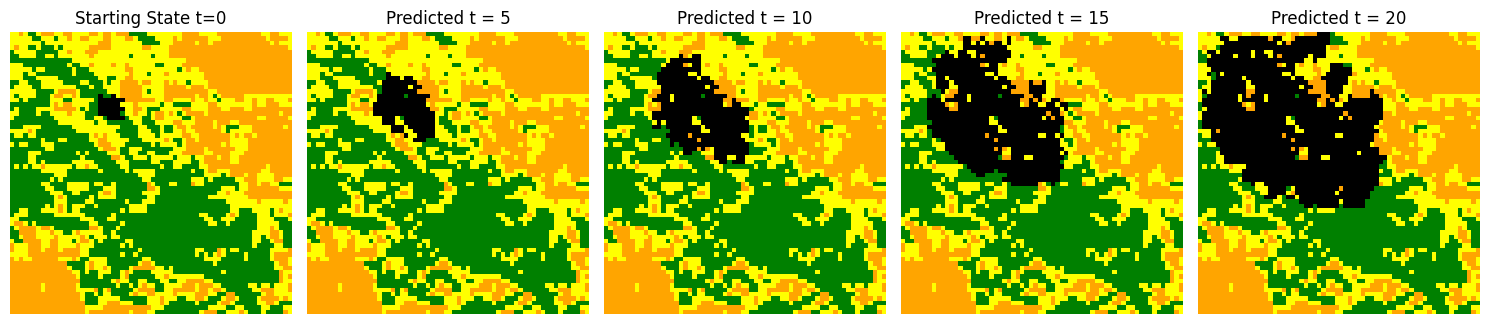

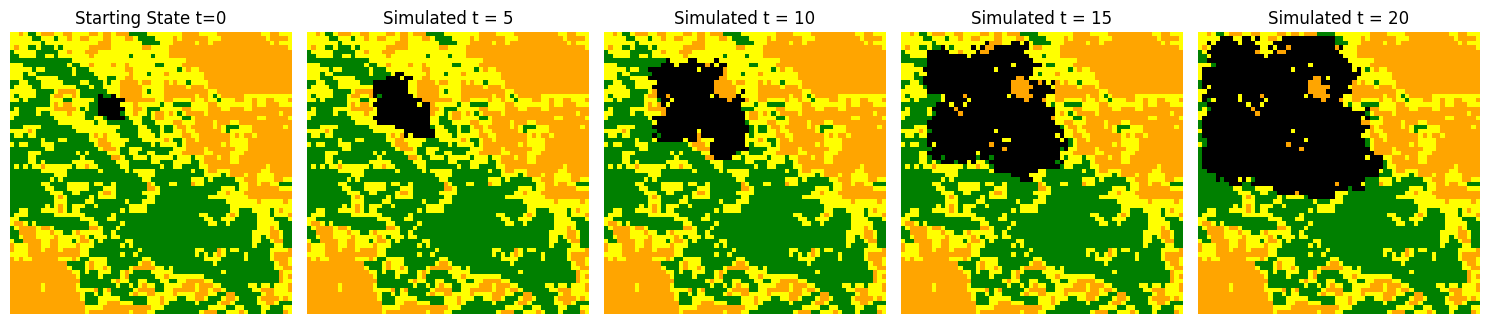

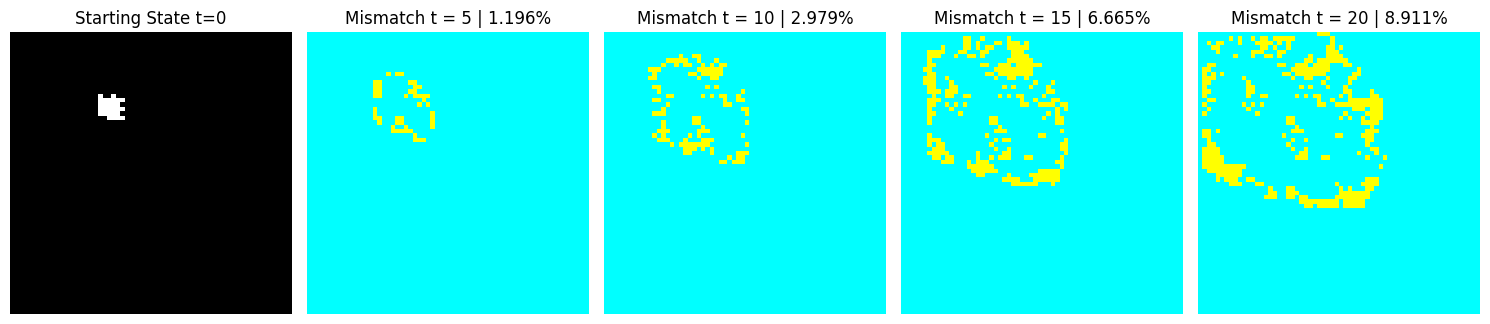

96 112


sampling loop time step: 100%|██████████| 500/500 [00:21<00:00, 23.22it/s]


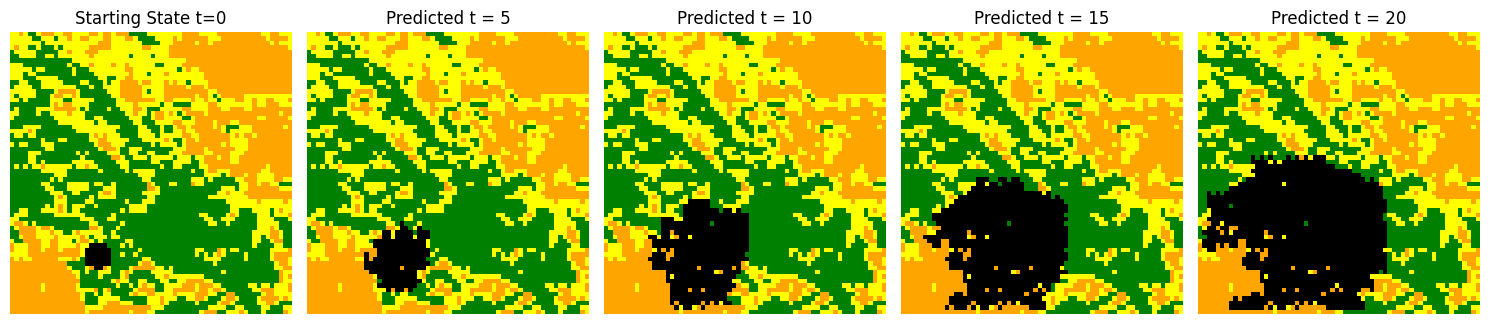

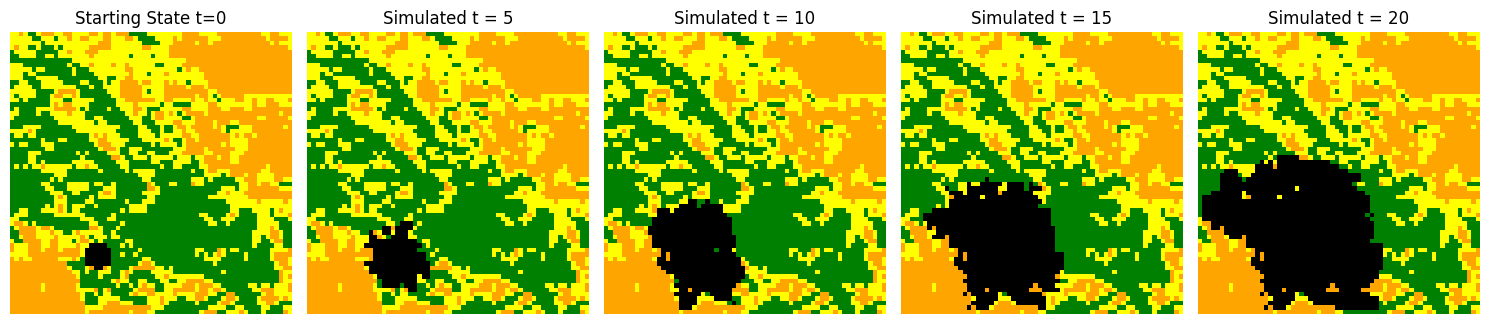

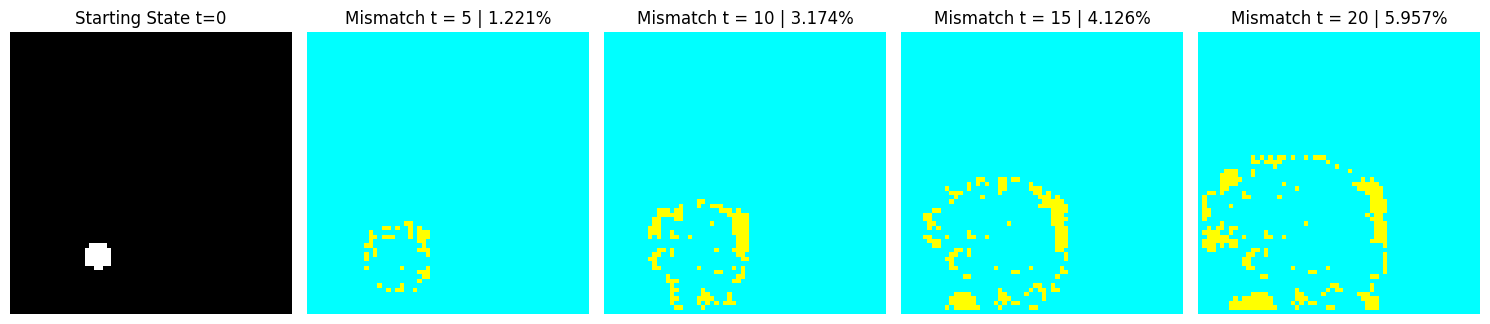

112 128


sampling loop time step: 100%|██████████| 500/500 [00:22<00:00, 22.05it/s]


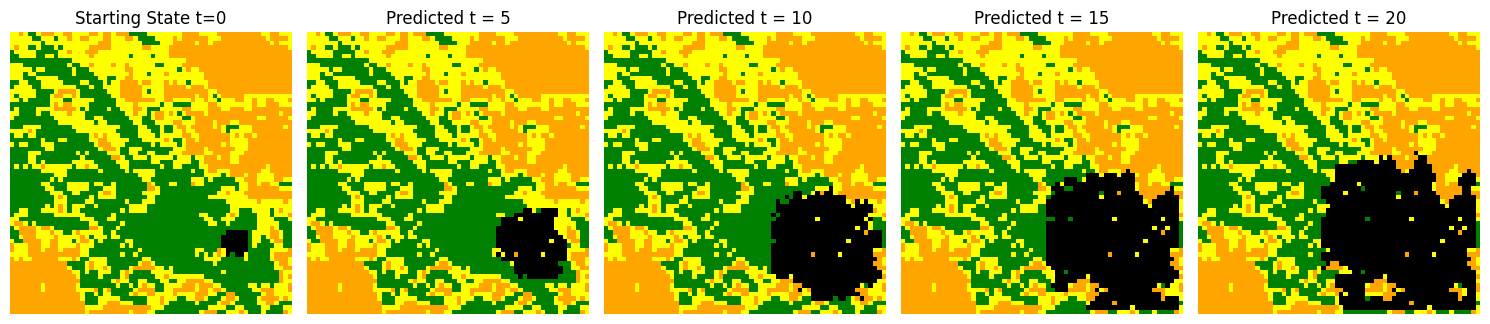

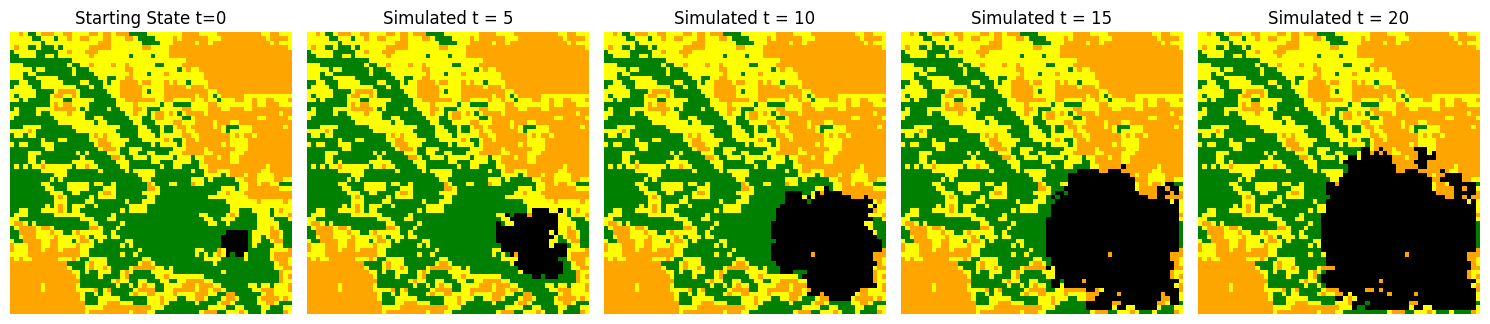

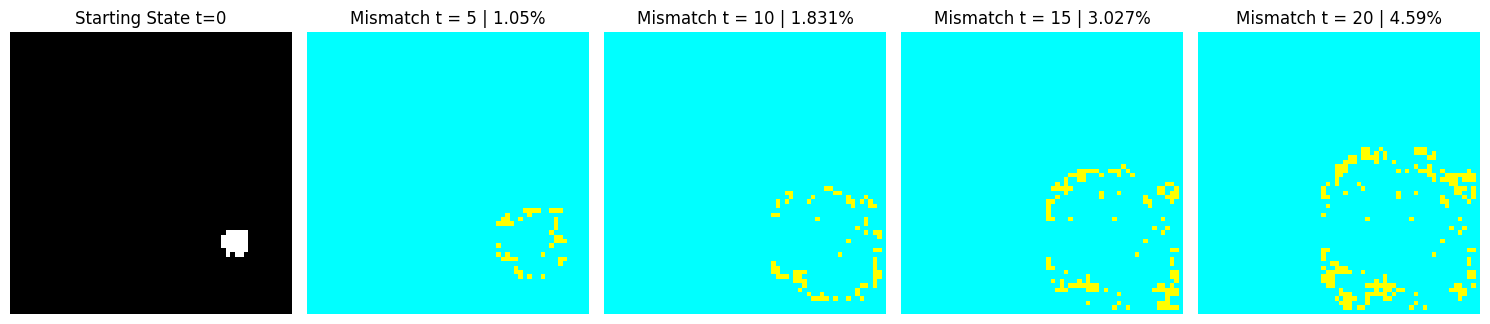

128 144


sampling loop time step: 100%|██████████| 500/500 [00:21<00:00, 22.95it/s]


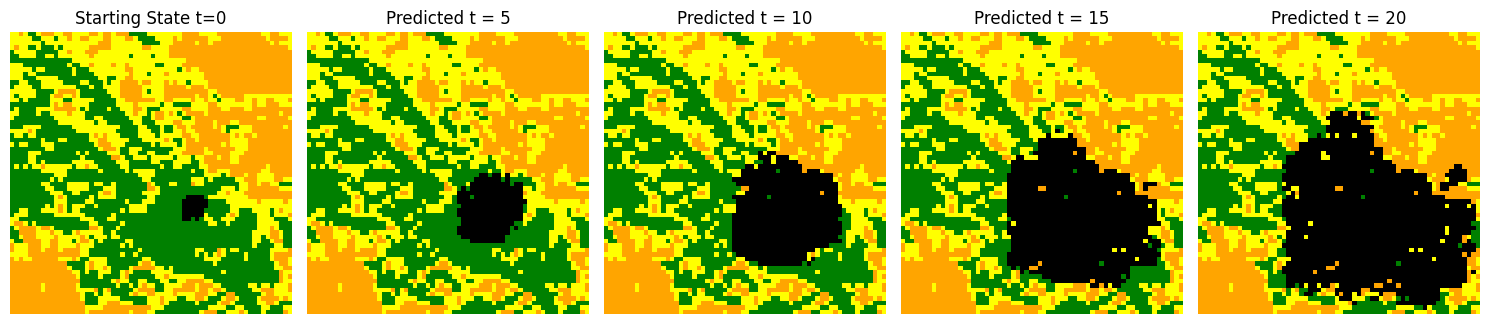

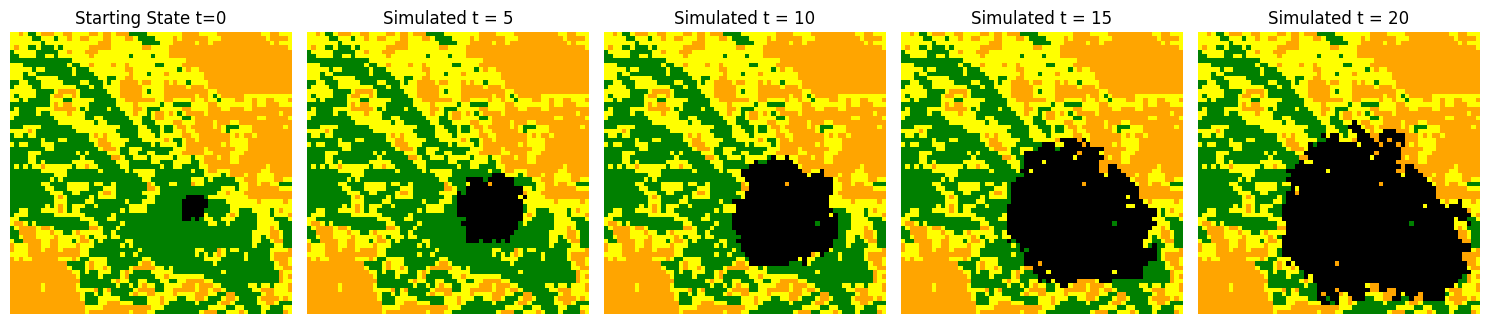

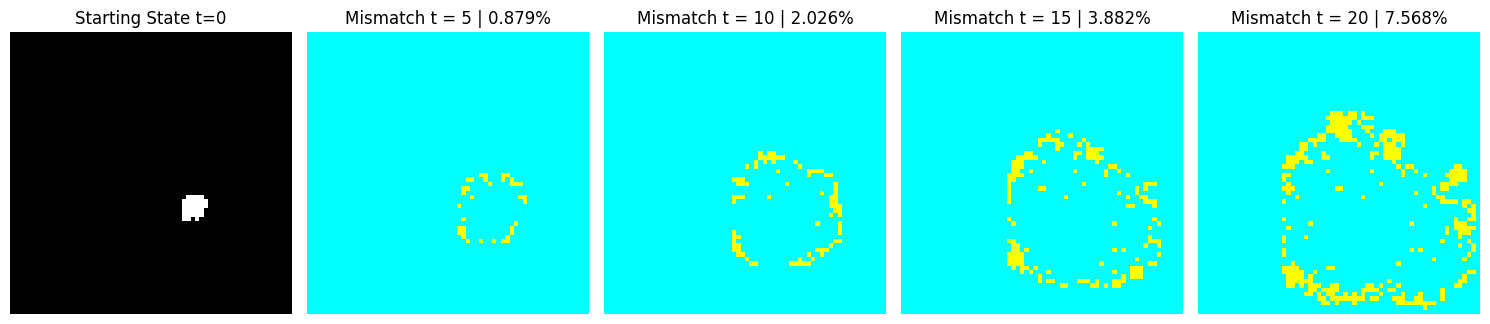

144 160


sampling loop time step: 100%|██████████| 500/500 [00:20<00:00, 24.23it/s]


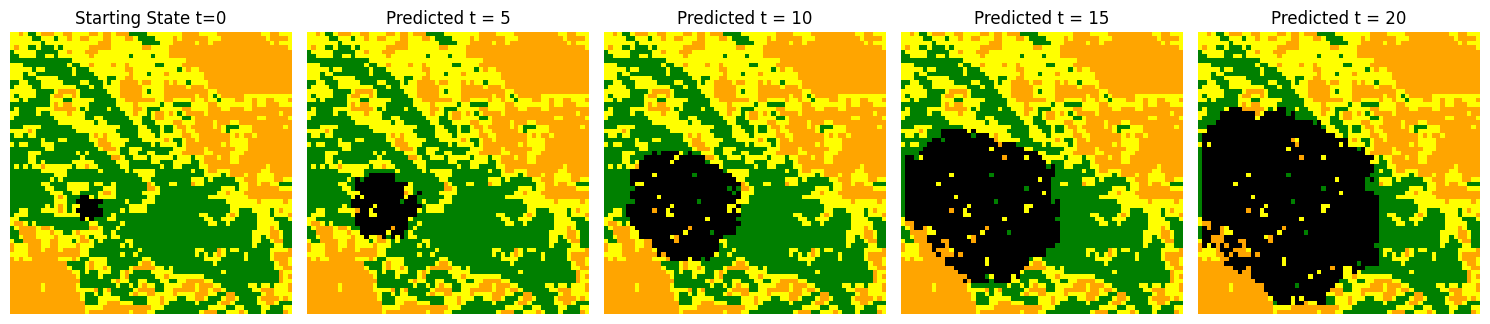

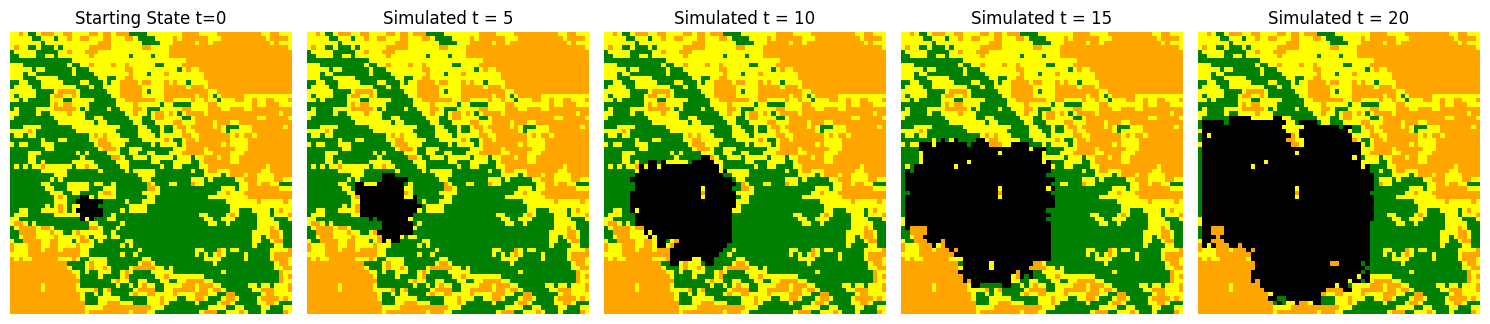

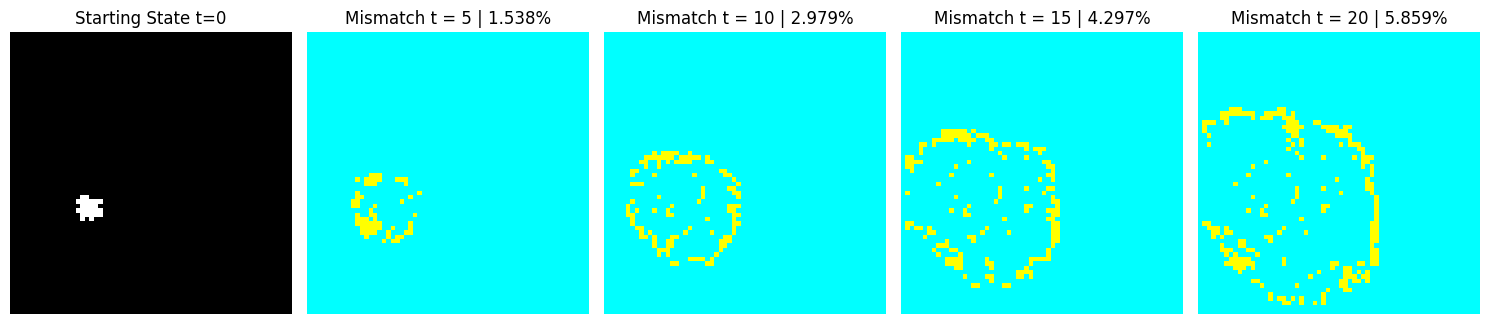

In [100]:
batch_size = 16
for batch in range(5, 10):
    start_index = batch * batch_size
    end_index = start_index + batch_size
    print(start_index, end_index)
    
    data = [simulated_data[i] for i in range(start_index, end_index)]
    
    input_img = data[0][1]
    
    outputs = generate_predictions(input_img, diffusion)

    plot_images_in_row(outputs, input_img, type_output="predicted")

    ground_truth = []
    for i in range(0, len(data), 5):
        ground_truth.append(data[i][0].squeeze())
        
    plot_images_in_row(ground_truth, input_img)
    
    mismatch = []
    mismatch_percentages = []
    for i in range(4):
        predicted = outputs[i]
        simulated = ground_truth[i]
        mismatch_image, mismatch_percentage = compute_pixel_mismatch(predicted, simulated)
        mismatch.append(mismatch_image)
        mismatch_percentages.append(mismatch_percentage)
        
        
    plot_images_in_row(mismatch, input_img, type_output="mismatch", mismatch_stat=mismatch_percentages)
